# Reactor Kinetics Example 

Jialu Wang (jwang44@nd.edu) and Alex Dowling (adowling@nd.edu)

University of Notre Dame

This notebook conducts design of experiments for a reactor kinetics experiment with the Pyomo.DOE.
    

In [1]:
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

import numpy as np
from scipy.interpolate import interp2d
import pandas as pd 
from itertools import permutations, product, combinations

from DoE_package import *
from pyomo.contrib.sensitivity_toolbox.sens import sipopt

## Define Reaction Example Mathematical Model

Consider two chemical reactions that converts molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goals is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

Using the **CCSI$^2$ toolset**, we would like do the following perform:

Perform **uncertainty quantification** and **design of experiments** on a small-scale **batch reactor** to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch reactor

The concenrations in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [2]:
from reactor_models import *

Three versions of this model is accomplished: 

Dynamic-DAE model: Temperature varying model discretized and integrated by Pyomo.DAE

Constant-DAE model: Temperature constant model discretized and integrated by Pyomo.DAE

Constant-analytical model: Temperature constant model discretized manually and using the analytical expressions for state variables.

In [3]:
# choose model from 'dynamic-DAE', 'constant-DAE', 'constant-analytical'
model_opt = 'dynamic-DAE'
#model_opt = 'constant-DAE'
#model_opt = 'constant-analytical'

if (model_opt=='dynamic-DAE'):
    createmod = create_model_dae
    disc = discretizer
    t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    
elif (model_opt=='constant-DAE'):
    createmod = create_model_dae_const
    disc = discretizer
    t_control = [0]
    
elif (model_opt=='constant-analytical'):
    createmod = create_model_alge
    disc = None
    t_control = [0]

    
# design variable and its control time set
dv_pass = {'CA0': [0],'T': t_control}
    
# Define measurement time points
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

In [4]:
# Define parameter nominal value 
parameter_dict = {'A1': 84.79085853498033, 'A2': 371.71773413976416, 'E1': 7.777032028026428, 'E2': 15.047135137500822}

def generate_exp(t_set, CA0, T):  
    '''Generate experiments. 
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 
    '''
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]
        
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In [5]:
# empty prior
#prior_all = np.zeros((4,4))


# add prior information
prior_5_300 = pd.read_csv('fim_5_300_scale.csv')
prior_5_300_500 = pd.read_csv('fim_5_300_500_scale.csv')

prior_all = prior_5_300_500


prior_pass=np.asarray(prior_all)

#L_initials = np.linalg.cholesky(prior_pass)
#print(L_initials)

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigvals(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigh(prior_pass)[1])

The prior information FIM: [[  28.67892806    5.41249739  -81.73674601  -24.02377324]
 [   5.41249739   26.40935036  -12.41816477 -139.23992532]
 [ -81.73674601  -12.41816477  240.46276004   58.76422806]
 [ -24.02377324 -139.23992532   58.76422806  767.25584508]]
Prior Det: 140189.67370995492
Eigenvalue of the prior experiments FIM: [8.00463185e+02 2.60471503e+02 4.84545259e-01 1.38765050e+00]
Eigenvalue of the prior experiments FIM: [[-0.77629273 -0.54211788  0.31871243 -0.0435912 ]
 [ 0.56614148 -0.80478003 -0.01425817 -0.177791  ]
 [-0.25919275 -0.19059651 -0.94009108  0.11278677]
 [ 0.09834911 -0.14869526  0.12019924  0.97661114]]


## Compute FIM 

This method computes an MBDoE optimization problem with no Degree of Freedom.

In [6]:
# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
#sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
sensi_opt = 'sequential_kaug'

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

print('Design variable:', exp1)

Design variable: {'CA0': {0: 5}, 'T': {0: 570.21, 0.125: 300, 0.25: 300, 0.375: 300, 0.5: 300, 0.625: 300, 0.75: 300, 0.875: 300, 1: 300}}


In [7]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)


if_s = True
result = doe_object.compute_FIM(exp1,mode=sensi_opt, FIM_store_name = 'dynamic.csv', scale_nominal_param_value=if_s, formula='central')


if sensi_opt == 'simultaneous_finite':
    result.extract_FIM(doe_object.m, doe_object.design_timeset,
                                                          doe_object.square_result, doe_object.obj_opt)
else: 
    result.calculate_FIM(doe_object.jac, doe_object.design_values)

Sensitivity information is scaled by its corresponding parameter nominal value.
perturb names are: ['A1_pert', 'A2_pert', 'E1_pert', 'E2_pert']
Perturbation parameters are set:
A1_pert :  83.94294994963053
A2_pert :  371.71773413976416
E1_pert :  7.777032028026428
E2_pert :  15.047135137500822
Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     2955
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      281

Tota

dsdp_mode=
E[[DOT_SENS]]...	[MAIN]No "f_timestamp" suffix declared. Fallback to default filename.

I[[DOT_SENS]]...	[MAIN] dsdp_in_.in
I[[DOT_SENS]]...	[MAIN]File read succesful.
I[[DOT_SENS]]...	[MAIN]Number of variables 865
I[[DOT_SENS]]...	[MAIN]Number of constraints 865
I[[DOT_SENS]]...	[MAIN]Number of rows (primal-dual) 1730


I[[DOT_SENS]]...	[MAIN]dsdp_mode_active

I[[DOT_SENS]]...	[DSDP_STRATEGY]Number of parameters detected  4
I[[DOT_SENS]]...	[MAIN]bye!.	Done.
I[[DOT_SENS]]...	[MAIN]Timing..0.007993 sec.
[[5.0, 0.6832750353394478, 0.42943599121105774, 0.2698933785431825, 0.1696199791728075, 0.10659893078129046, 0.06699152119443698, 0.04209960855357131, 0.026456207096238946, 0.0, 1.4352505712331582, 1.523001064451413, 1.5126471751759896, 1.447541769219542, 1.354205549113907, 1.2486557820351374, 1.1403764385473907, 1.0348065168209184, 0.0, 2.8814743934273936, 3.047562944337529, 3.2174594462808273, 3.38283825160765, 3.539195520104802, 3.684352696770426, 3.817523952899038, 3.9387

dsdp_mode=
E[[DOT_SENS]]...	[MAIN]No "f_timestamp" suffix declared. Fallback to default filename.

I[[DOT_SENS]]...	[MAIN] dsdp_in_.in
I[[DOT_SENS]]...	[MAIN]File read succesful.
I[[DOT_SENS]]...	[MAIN]Number of variables 865
I[[DOT_SENS]]...	[MAIN]Number of constraints 865
I[[DOT_SENS]]...	[MAIN]Number of rows (primal-dual) 1730


I[[DOT_SENS]]...	[MAIN]dsdp_mode_active

I[[DOT_SENS]]...	[DSDP_STRATEGY]Number of parameters detected  4
I[[DOT_SENS]]...	[MAIN]bye!.	Done.
I[[DOT_SENS]]...	[MAIN]Timing..0.008005 sec.
[[5.0, 0.6832750353394478, 0.42943599121105774, 0.2698933785431825, 0.1696199791728075, 0.10659893078129046, 0.06699152119443698, 0.04209960855357131, 0.026456207096238946, 0.0, 1.4352505712331582, 1.523001064451413, 1.5126471751759896, 1.447541769219542, 1.354205549113907, 1.2486557820351374, 1.1403764385473907, 1.0348065168209184, 0.0, 2.8814743934273936, 3.047562944337529, 3.2174594462808273, 3.38283825160765, 3.539195520104802, 3.684352696770426, 3.817523952899038, 3.9387

W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG]...	[K_AUG_ASL]This problem has no degrees of freedom
Pass the option square_override for the desired behaviour
[K_AUG] written by D.T. @2018

: dsdp_mode=
dsdp_mode=
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zL_out suffix declared, setting zL = 0.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dsdp_in_.in
W[K_AUG]...	[K_AUG_ASL]dsdp for linear C(x) + I*p = 0 override.
W[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.0424246; Max residual ratio 1e-10.

I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_

   2  0.0000000e+00 1.65e+01 9.45e+01  -1.0 5.99e+01    -  1.18e-01 9.90e-01h  1
   3  0.0000000e+00 6.41e-02 5.96e+01  -1.0 1.03e+01    -  8.22e-01 1.00e+00h  1
   4  0.0000000e+00 1.60e-10 2.78e+02  -1.0 3.41e-02    -  9.92e-01 1.00e+00h  1

Number of Iterations....: 4

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   1.5974421785358572e-10    1.5974421785358572e-10
Complementarity.........:   0.0000000000000000e+00    0.0000000000000000e+00
Overall NLP error.......:   1.5974421785358572e-10    1.5974421785358572e-10


Number of objective function evaluations             = 5
Number of objective gradient evaluations             = 5
Number of equality constraint evaluations            = 5
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian ev

In [8]:
print('======Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))

======Result summary======
Four design criteria log10() value:
A-optimality: 3.2244051269190375
D-optimality: 6.212940042263111
E-optimality: 0.011831455151144811
Modified E-optimality: 3.1275980838863466


### Run sequential DOE automatically

This method runs a series of experiments in a row.

In [10]:
# this only works for constant T mode. 
exp1 = generate_exp(t_control, 5, [300])
exp2 = generate_exp(t_control, 5, [500.92])
exp3 = generate_exp(t_control, 5, [528])
exp4 = generate_exp(t_control, 5, [546.8])
exp5 = generate_exp(t_control, 5, [562])

AssertionError: T should have the same length as t_set

In [ ]:

exp_all = [exp1, exp2, exp3, exp4, exp5]


doe_object = DesignOfExperiments(parameter_dict, dv_pass,
                                 ['CA','CB','CC'], t_measure, createmod,
                                prior_FIM=prior_pass, discretize_model=disc)

# choose from 'simultaneous', 'sequential', 'sipopt'
#sensi_opt = 'simultaneous_finite'
sensi_opt = 'sequential_finite'
#sensi_opt = 'sequential_sipopt'
if_s = True
result = doe_object.sequential_exp(exp_all, mode=sensi_opt, tee_option=True,
                                    scale_nominal_param_value=if_s, formula='central')

In [ ]:
print('=======Result summary=======')
for i in range(len(exp_all)):
    print('The ', i+1,'th experiment has optimality log10() values:')
    print('A-optimality:', np.log10(result[0][i].trace))
    print('D-optimality:', np.log10(result[0][i].det))
    print('E-optimality:', np.log10(result[0][i].min_eig))
    print('Modified E-optimality:', np.log10(result[0][i].cond))

## Optimization

In [12]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

square_result, optimize_result = doe_object.optimize_doe(exp1, if_optimize=True, if_Cholesky=True, scale_nominal_param_value=True, objective_option='det', L_initial=None)


Sensitivity information is scaled by its corresponding parameter nominal value.
Ipopt 3.13.3: linear_solver=ma57
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    24144
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1922

Total number of variables............................:     6406
                     variables with only lower bounds:     2316
                variables with lower and upper bounds:       88
                     variab

FIM: [[  46.24824873   24.02029597 -111.11259575  -98.84096347]
 [  24.02029597   56.00750616  -41.77758393 -257.36193473]
 [-111.11259575  -41.77758393  290.34323271  177.30691662]
 [ -98.84096347 -257.36193473  177.30691662 1245.84730921]]
Trace: 1638.4462968124803
Determinant: 1637264.3239264484
Condition number: 1318.2046058189794
Minimal eigen value: 1.018082460753852
Eigen values: [1.34204099e+03 2.91273175e+02 1.01808246e+00 4.11405006e+00]
Eigen vectors: [[ 0.09222082 -0.33473764 -0.67734443  0.64857579]
 [ 0.19945077  0.02109713  0.6862249   0.69919216]
 [-0.1793339   0.9206072  -0.23558824  0.25459757]
 [-0.95893382 -0.19997003  0.12164738  0.16018689]]
Model objective: 14.308537311814217
Objective(determinant) is: 1637264.3239272628
Solution of  CA0  : [5.0]
Solution of  T  : [579.2123483692055, 300.00000829024395, 300.00001529530726, 300.00002224158675, 300.0000306452559, 300.0000437403924, 300.0000694587363, 300.00014505287686, 300.00044564425997]
======problem solver outp

In [13]:
print('======Result summary======')
print('This optimization is solved with status:', optimize_result.status)
print('It gives solution:', optimize_result.solution)
print('The log10(OF) optimized is:', optimize_result.obj_value)
print('The result FIM is:', optimize_result.FIM)

======Result summary======
This optimization is solved with status: converged
It gives solution: {'CA0': [5.0], 'T': [579.2123483692055, 300.00000829024395, 300.00001529530726, 300.00002224158675, 300.0000306452559, 300.0000437403924, 300.0000694587363, 300.00014505287686, 300.00044564425997]}
The log10(OF) optimized is: 14.308537311814217
The result FIM is: [[  46.24824873   24.02029597 -111.11259575  -98.84096347]
 [  24.02029597   56.00750616  -41.77758393 -257.36193473]
 [-111.11259575  -41.77758393  290.34323271  177.30691662]
 [ -98.84096347 -257.36193473  177.30691662 1245.84730921]]


## Grid search for 2 design variables

In [17]:
design_ranges = [list(np.linspace(1,5,5)), list(np.linspace(300,700,5))]

dv_apply_name = ['CA0','T']

dv_apply_time = [[0],t_control]

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

In [18]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True
                                    )

25  design vectors will be searched.
=======This is the  1 th iteration=======
Design variable values of this iteration: {'CA0': {0: 1.0}, 'T': {0: 300.0, 0.125: 300.0, 0.25: 300.0, 0.375: 300.0, 0.5: 300.0, 0.625: 300.0, 0.75: 300.0, 0.875: 300.0, 1: 300.0}}
Sensitivity information is scaled by its corresponding parameter nominal value.
Existed information has been added.
FIM: [[  29.58003272    5.48612156  -84.54627162  -24.46790912]
 [   5.48612156   27.13328151  -12.64771469 -143.60704229]
 [ -84.54627162  -12.64771469  249.22249067   60.14898186]
 [ -24.46790912 -143.60704229   60.14898186  793.6004921 ]]
Trace: 1099.5362969973296
Determinant: 151638.49432111066
Condition number: 1703.570882096611
Minimal eigen value: 0.48581739042098304
Eigen values: [8.27624360e+02 2.70029455e+02 4.85817390e-01 1.39666420e+00]
Eigen vectors: [[ 0.04300749 -0.31822906 -0.77652374  0.54211761]
 [ 0.17730502  0.01420751  0.56599113  0.80499386]
 [-0.1117473   0.94040674 -0.25890023  0.19004834]
 [-

Existed information has been added.
FIM: [[  29.66284896    5.98404272  -83.57738856  -26.09248409]
 [   5.98404272   27.73909098  -13.48736761 -144.05292682]
 [ -83.57738856  -13.48736761  243.90609069   62.63421243]
 [ -26.09248409 -144.05292682   62.63421243  784.67652324]]
Trace: 1085.9845538701272
Determinant: 188639.46155960692
Condition number: 1474.5971887933822
Minimal eigen value: 0.556052063178459
Eigen values: [8.19952809e+02 2.63907946e+02 5.56052063e-01 1.56774623e+00]
Eigen vectors: [[ 0.04594253 -0.320668   -0.77534136  0.54213199]
 [ 0.17974722  0.01448798  0.56676229  0.80390394]
 [-0.11695823  0.93879944 -0.26038706  0.19280809]
 [-0.97565414 -0.12497097  0.09912039  0.15052047]]
This is the  8  run out of  25 run.
The code has run 10.2423 seconds.
Estimated remaining time: 21.7649 seconds
=======This is the  9 th iteration=======
Design variable values of this iteration: {'CA0': {0: 2.0}, 'T': {0: 600.0, 0.125: 600.0, 0.25: 600.0, 0.375: 600.0, 0.5: 600.0, 0.625: 60

Existed information has been added.
FIM: [[  43.09660269    6.59048419 -126.68915571  -31.12994736]
 [   6.59048419   37.99224879  -16.09096346 -209.11379689]
 [-126.68915571  -16.09096346  380.61845015   80.9202888 ]
 [ -31.12994736 -209.11379689   80.9202888  1188.77019715]]
Trace: 1650.4774987815367
Determinant: 377289.91439240717
Condition number: 2481.5331584244427
Minimal eigen value: 0.4977587555539962
Eigen values: [1.23520486e+03 4.13290103e+02 4.97758756e-01 1.48478063e+00]
Eigen vectors: [[ 0.03730531 -0.3135781  -0.77866613  0.54217722]
 [ 0.1725762   0.01383184  0.56460354  0.80699999]
 [-0.10148488  0.9433793  -0.25614111  0.18473777]
 [-0.97904371 -0.10729839  0.09640345  0.14375966]]
This is the  16  run out of  25 run.
The code has run 20.5361 seconds.
Estimated remaining time: 11.5516 seconds
=======This is the  17 th iteration=======
Design variable values of this iteration: {'CA0': {0: 4.0}, 'T': {0: 400.0, 0.125: 400.0, 0.25: 400.0, 0.375: 400.0, 0.5: 400.0, 0.625:

Existed information has been added.
FIM: [[  32.4619363     7.89946484  -87.63421063  -31.52510018]
 [   7.89946484   30.55560188  -16.29518684 -151.74607207]
 [ -87.63421063  -16.29518684  249.65652506   70.45831361]
 [ -31.52510018 -151.74607207   70.45831361  804.97755722]]
Trace: 1117.651620471588
Determinant: 454517.0126153976
Condition number: 1059.799723292563
Minimal eigen value: 0.7970814142579506
Eigen values: [8.44746662e+02 2.69604107e+02 7.97081414e-01 2.50377024e+00]
Eigen vectors: [[ 0.05337759 -0.32661762 -0.74037869  0.58507364]
 [ 0.18442587  0.01338178  0.61386088  0.76745217]
 [-0.12811295  0.93486205 -0.25133676  0.21552227]
 [-0.97299795 -0.13847311  0.10883033  0.14918496]]
This is the  24  run out of  25 run.
The code has run 31.3061 seconds.
Estimated remaining time: 1.3044 seconds
=======This is the  25 th iteration=======
Design variable values of this iteration: {'CA0': {0: 5.0}, 'T': {0: 700.0, 0.125: 700.0, 0.25: 700.0, 0.375: 700.0, 0.5: 700.0, 0.625: 700

### 1D sensitivity curve

Design variable:  ['CA0', 'T']
Value          :  (1.0, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 600.0)
Design variable:  ['CA0', 'T']
Value          :  (1.0, 700.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 600.0)
Design variable:  ['CA0', 'T']
Value          :  (2.0, 700.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 300.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 400.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 500.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 600.0)
Design variable:  ['CA0', 'T']
Value          :  (3.0, 700.0)
Design variable:  ['CA0', 'T']
Value          :  (4.0, 300.0)
Design v

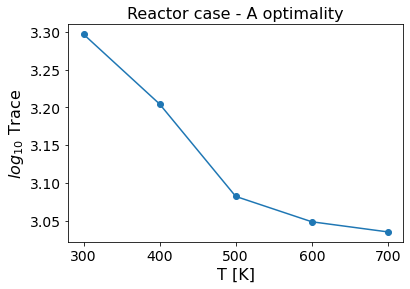

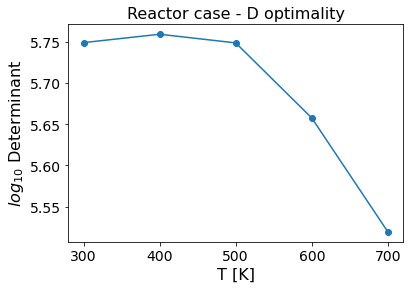

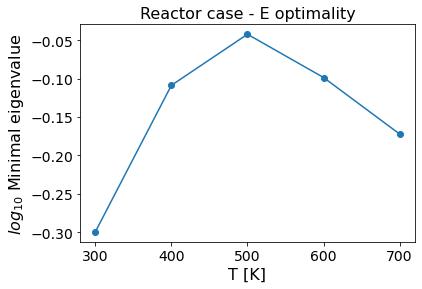

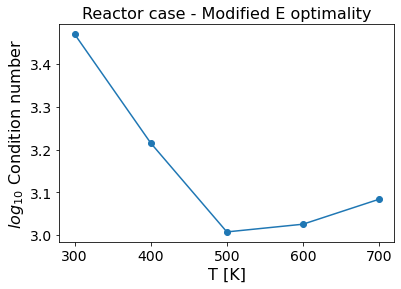

In [19]:
test = all_fim.extract_criteria()

## draw 1D sensitivity curve 

fixed = {"'CA0'": 5.0}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )



## Heatmap

2D heatmap is plotted with  ['CA0', 'T'] .


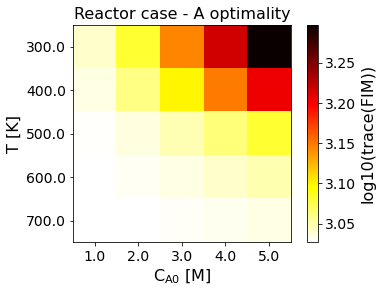

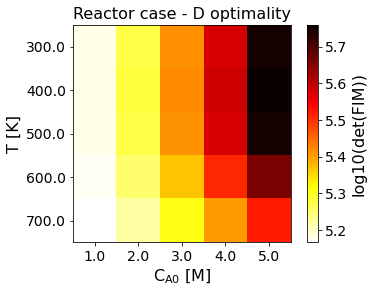

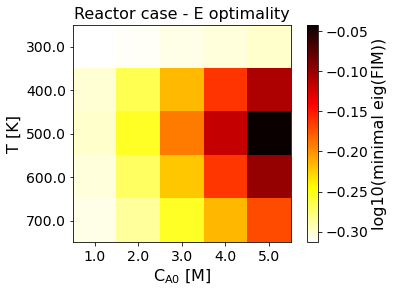

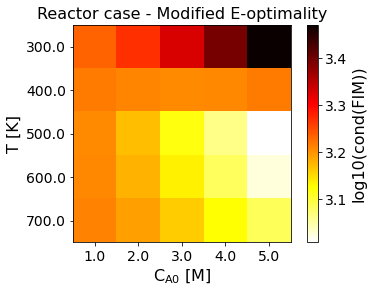

In [21]:
fixed = {}
all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

## Grid search for 3 design variables

In [22]:

design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]

dv_apply_name = ['CA0', 'T', 'T']
dv_apply_time = [[0], [0], [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875,1]]

# Define experiments
if (model_opt=='dynamic-DAE'):
    exp1 = generate_exp(t_control, 5, [570.21, 300, 300, 300, 300, 300, 300, 300, 300])
else: 
    exp1 = generate_exp(t_control, 5, [500])

In [23]:
doe_object = DesignOfExperiments(parameter_dict, dv_pass, 
                                 ['CA','CB','CC'], t_measure, createmod,
                                 prior_FIM=prior_pass, discretize_model=disc)

all_fim = doe_object.run_grid_search(exp1, design_ranges,dv_apply_name, dv_apply_time, 
                                     mode='sequential_finite', 
                                    scale_nominal_param_value=True
                                    )

8  design vectors will be searched.
=======This is the  1 th iteration=======
Design variable values of this iteration: {'CA0': {0: 1.0}, 'T': {0: 300.0, 0.125: 300, 0.25: 300, 0.375: 300, 0.5: 300, 0.625: 300, 0.75: 300, 0.875: 300, 1: 300}}
Sensitivity information is scaled by its corresponding parameter nominal value.
Existed information has been added.
FIM: [[  29.58003272    5.48612156  -84.54627162  -24.46790912]
 [   5.48612156   27.13328151  -12.64771469 -143.60704229]
 [ -84.54627162  -12.64771469  249.22249067   60.14898186]
 [ -24.46790912 -143.60704229   60.14898186  793.6004921 ]]
Trace: 1099.5362969973296
Determinant: 151638.49432111066
Condition number: 1703.570882096611
Minimal eigen value: 0.48581739042098304
Eigen values: [8.27624360e+02 2.70029455e+02 4.85817390e-01 1.39666420e+00]
Eigen vectors: [[ 0.04300749 -0.31822906 -0.77652374  0.54211761]
 [ 0.17730502  0.01420751  0.56599113  0.80499386]
 [-0.1117473   0.94040674 -0.25890023  0.19004834]
 [-0.97684483 -0.119

### Draw 1D sensitivity curve

In [24]:
test = all_fim.extract_criteria()

Design variable:  ['CA0', 'T', 'T']
Value          :  (1.0, 300.0, 300)
Design variable:  ['CA0', 'T', 'T']
Value          :  (1.0, 300.0, 500)
Design variable:  ['CA0', 'T', 'T']
Value          :  (1.0, 700.0, 300)
Design variable:  ['CA0', 'T', 'T']
Value          :  (1.0, 700.0, 500)
Design variable:  ['CA0', 'T', 'T']
Value          :  (5.0, 300.0, 300)
Design variable:  ['CA0', 'T', 'T']
Value          :  (5.0, 300.0, 500)
Design variable:  ['CA0', 'T', 'T']
Value          :  (5.0, 700.0, 300)
Design variable:  ['CA0', 'T', 'T']
Value          :  (5.0, 700.0, 500)


["'CA0'", "'T2'"] is/are fixed.
1D sensitivity curve is plotted with  T .


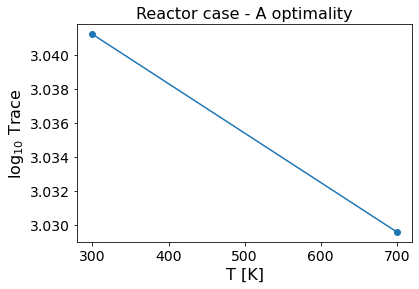

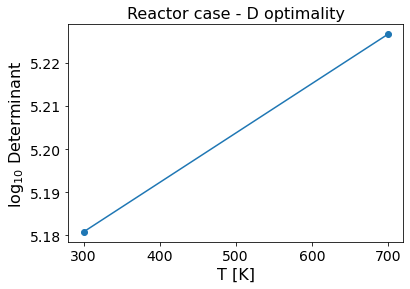

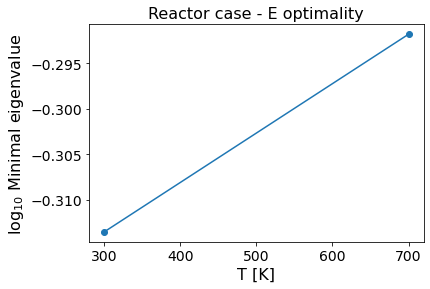

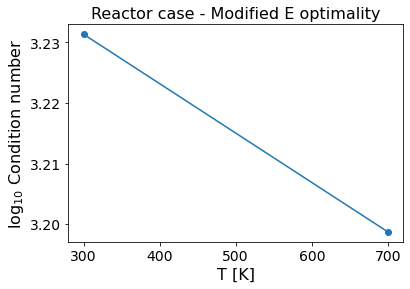

In [25]:
## draw 1D sensitivity curve 

fixed = {"'CA0'": 1.0, "'T2'": 300}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

### Draw 2D sensitivity curve

["'T2'"] is/are fixed.
2D heatmap is plotted with  ['CA0', 'T'] .


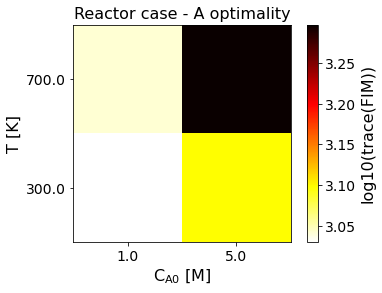

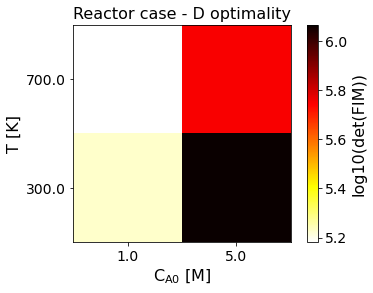

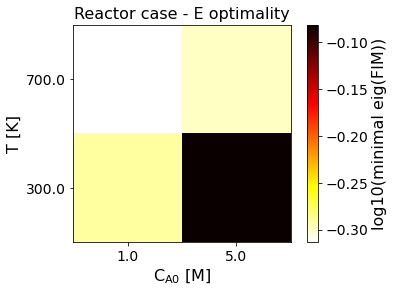

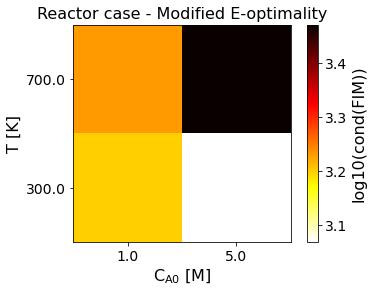

In [26]:
fixed = {"'T2'": 300}

all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )